In [1]:
#These are the required libraries. To install them, you can uncomment the following lines and run the script.
#%pip install tensorflow
#%pip install pandas
#%pip install opencv-python
#%pip install numpy
#%pip install matplotlib
#%pip install mtcnn
#%pip install scikit-learn

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
import random

In [3]:
dataset = "expressions_dataset"
detector = MTCNN()

In [4]:
#Pre-processing every image takes approximately 10 minutes
faces = []
labels = []
img_size = [112, 112]

total_images = sum(len(files) for _, _, files in os.walk(dataset))

for label, expression_folder in enumerate(os.listdir(dataset)):
    expression_folder = os.path.join(dataset, expression_folder)
    for filename in os.listdir(expression_folder):
        image_path = os.path.join(expression_folder, filename)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces_found = detector.detect_faces(image_rgb)
        if(faces_found):
            x, y, w, h = faces_found[0]['box']
            face_image = image_rgb[y:y+h, x:x+w]
            face_image = cv2.resize(face_image, (img_size))
            faces.append(face_image)
            labels.append(label)

        if len(faces_found) == 0:
            continue

faces = np.array(faces)
labels = np.array(labels)

1/1 [==============================] - 0s 20ms/step


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, labels, test_size=0.2, random_state=42)

In [ ]:
x_train = np.array(x_train,dtype='float32')/255
x_test = np.array(x_test,dtype='float32')/255

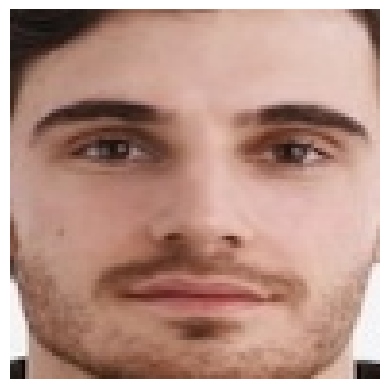

In [ ]:
#Show random image from dataset pre-processed by MTCNN
random_index = random.randint(0, x_train.shape[0] - 1)
random_image = x_train[random_index]
plt.imshow(random_image)
plt.axis('off')
plt.show()

In [ ]:
x_train, x_valid, y_train, y_valid= train_test_split(
    x_train, y_train, test_size=0.20, random_state=42)


In [ ]:
batch_size=128
epochs = 120
steps_per_epoch = 3
img_shape=(112, 112, 3)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *img_shape)
x_test = x_test.reshape(x_test.shape[0], *img_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *img_shape)

In [ ]:
cnn_model = Sequential([
    Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=img_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=8, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu',  kernel_regularizer=regularizers.l2(0.12)),
    Dropout(0.3),
    Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.17)),
    Dropout(0.12)
])

In [ ]:
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

cnn_model.summary()

history=cnn_model.fit(
    np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=epochs, verbose=2, steps_per_epoch=steps_per_epoch,
    shuffle=True,
    validation_data=(np.array(x_valid), np.array(y_valid))
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 8)         1160      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 8)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3872)              0         
                                                                 
 dense_10 (Dense)            (None, 128)              

9/9 [==============================] - 0s 3ms/step - loss: 1.4341 - accuracy: 0.7744
test loc 1.4341
test acc 0.7744
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


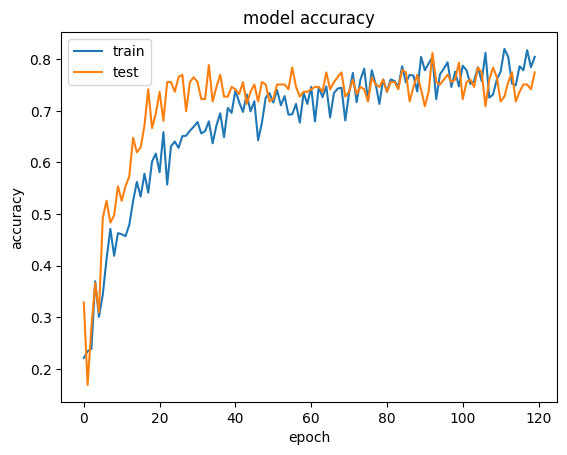

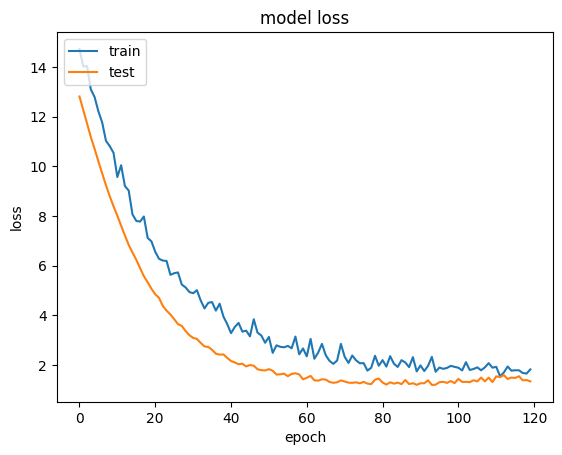

In [ ]:
scor = cnn_model.evaluate(np.array(x_test), np.array(y_test), verbose=1)
print('test loc {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9/9 [==============================] - 0s 2ms/step


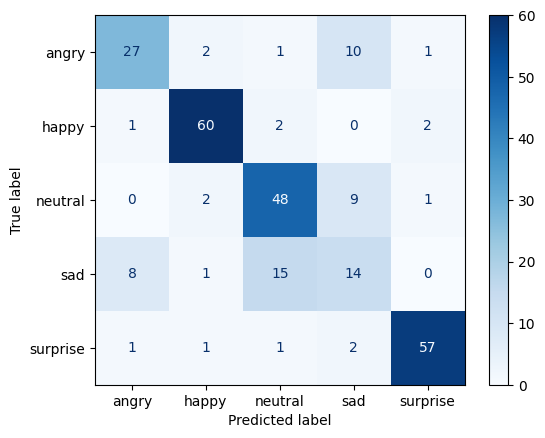

Precision for angry: 0.73
Precision for happy: 0.91
Precision for neutral: 0.72
Precision for sad: 0.40
Precision for surprise: 0.93


In [ ]:
y_pred = np.argmax(cnn_model.predict(x_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

classes = ['angry', 'happy', 'neutral', 'sad', 'surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

class_precisions = precision_score(y_test, y_pred, average=None)

for class_name, precision_value in zip(classes, class_precisions):
    print("Precision for", class_name + ":", "%.2f" % precision_value)

In [ ]:
model_save_path = 'RoboticsExpressionModel.h5'
cnn_model.save(model_save_path)

C:\Users\pawel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
